In [17]:
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch

In [77]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl
from flwr.common import Metrics
import random
import torch.nn as nn
DEVICE = torch.device("cpu")

In [73]:
consumers = [i for i in range(1, 51)]
training_consumers = random.sample(consumers, int(0.8*len(consumers)))
test_consumers = [i for i in consumers if i not in training_consumers]

In [72]:
test_consumers

[6, 7, 17, 20, 22, 27, 28, 31, 41, 47]

In [159]:
class RegressionData(Dataset):
    def __init__(self, path):
        df = pd.read_csv(path)
        self.x = df['appliances'].values
    
    def __len__(self):
        return (len(self.x) // 96) - 8
    
    def __getitem__(self, idx):
        if idx > 358:
            raise Exception('Unbounded window')
        return torch.tensor(self.x[idx*96:(idx+7)*(96)], dtype=torch.float32), torch.tensor(self.x[(idx+7)*96:(idx+8)*96], dtype=torch.float32)

In [160]:
dataset = RegressionData(f'./data/Consumer2.csv')

In [161]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, dataset):
        self.net = net
        self.dataset = dataset

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.dataset, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


In [202]:
class MyRNN(nn.Module):
    def __init__(self, hid_size, output_dim):
        super(MyRNN, self).__init__()
        self.hidden_size = hid_size
        self.output_dim = output_dim
        self.rnn = nn.RNN(input_size=1, hidden_size=self.hidden_size, num_layers=1)
        self.fc1 = nn.Linear(self.hidden_size, 1)

    def forward(self, inputs, hidden_state):
        outputs = []
        inputs = inputs.view(-1, 1)
        output, hidden_states = self.rnn(inputs, hidden_state)
        output = self.fc1(output)
        return output, hidden_states

In [206]:
len(dataset)

358

In [276]:
def train(net):
    """Train the network on the training set."""
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    net.train()
    val_losses = []
    for i in range(len(dataset)):
        x, Y = dataset[i]
        hidden_state = torch.zeros((1, net.hidden_size))
        _, hidden = net(x, hidden_state)
        output, _ = net(Y, hidden)
        loss = criterion(Y, output.squeeze())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        val_losses.append(loss.item())    
    return val_losses

In [277]:
model = MyRNN(5,20)

In [278]:
losses = train(model)

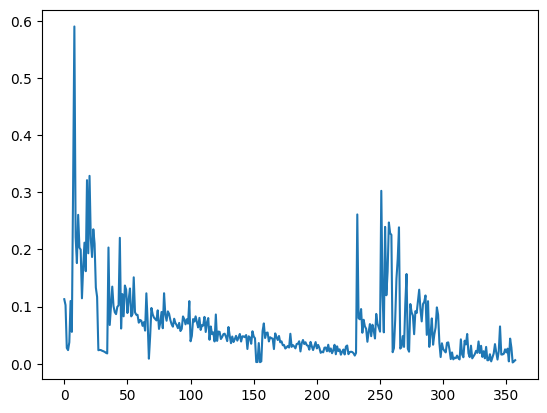

In [279]:
plt.plot(losses)

In [280]:
eval_dataset = RegressionData(f'./data/Consumer35.csv')

In [281]:
def test(net, dataset):
    """Train the network on the training set."""
    criterion = torch.nn.MSELoss()
    net.eval()
    val_losses = []
    outputs = []
    with torch.no_grad():
        for i in range(len(dataset)):
            x, Y = dataset[i]
            hidden_state = torch.zeros((1, net.hidden_size))
            _, hidden = net(x, hidden_state)
            output, _ = net(Y, hidden)
            loss = criterion(Y, output.squeeze())
            val_losses.append(loss.item())  
            outputs += list([max(0, i.item()) for i in output.squeeze()])
    return val_losses, outputs

In [282]:
loss, outs = test(model, eval_dataset)

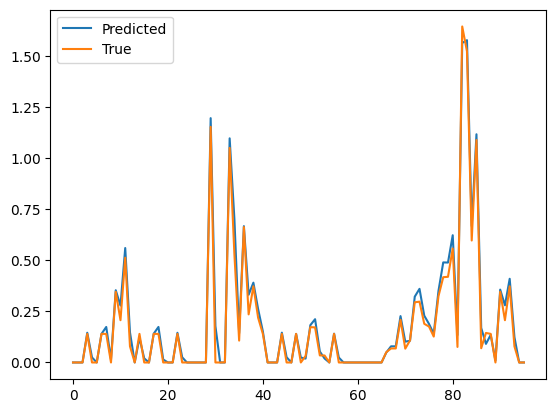

In [283]:
plt.plot(outs[:96], label='Predicted')
plt.plot(eval_dataset[0][1][:96], label='True')
plt.legend()
plt.show()

In [246]:
print(outs[:96])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.14332649111747742, 0.14463013410568237, 0, 0, 0, 0, 0.14289219677448273, 0, 0.14014892280101776, 0.14302709698677063, 0, 0, 0.14222286641597748, 0, 0, 0, 0, 0.1429065614938736, 0, 0, 0, 0, 0, 0, 0, 0.09797327220439911, 0, 0, 0.09662492573261261, 0.09929992258548737, 0, 0, 0, 0.09804625809192657, 0, 0, 0.09635818004608154, 0, 1.19595205783844, 1.0559782981872559, 0.2605840563774109, 0.12433917820453644, 0.016001775860786438, 0.021184444427490234, 0.12785808742046356, 0, 0, 0, 0, 0, 0, 0.04922552406787872, 0.04798421263694763, 0.04482169449329376, 0.04335404932498932, 0.04201729595661163, 0.0434427410364151, 0.046587809920310974, 0.04294072091579437, 0.042593494057655334, 0.043360427021980286, 0.04333032667636871, 0.042593225836753845, 0.19194823503494263, 0.042259395122528076, 0.037924543023109436, 0.19041845202445984, 0.14405542612075806, 0, 0, 0, 0.14330394566059113, 0, 0, 0.1412440538406372, 0, 0, 0.1416792869567871, 0.14475539326667786, 0, 0, 0, 0.14

In [247]:
print(eval_dataset[0][1][:96])

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1400, 0.1400, 0.0000, 0.0000, 0.0000, 0.0000, 0.1400, 0.0000,
        0.1400, 0.1400, 0.0000, 0.0000, 0.1400, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1400, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0980,
        0.0000, 0.0000, 0.0980, 0.0980, 0.0000, 0.0000, 0.0000, 0.0980, 0.0000,
        0.0000, 0.0980, 0.0011, 1.1139, 0.9844, 0.2554, 0.1486, 0.0332, 0.0320,
        0.1293, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0533, 0.0512,
        0.0494, 0.0487, 0.0472, 0.0486, 0.0515, 0.0482, 0.0480, 0.0487, 0.0486,
        0.0479, 0.1861, 0.0461, 0.0461, 0.1862, 0.1400, 0.0000, 0.0000, 0.0000,
        0.1400, 0.0000, 0.0000, 0.1400, 0.0000, 0.0000, 0.1400, 0.1400, 0.0000,
        0.0000, 0.0000, 0.1400, 0.0000, 0.0000, 0.0000])


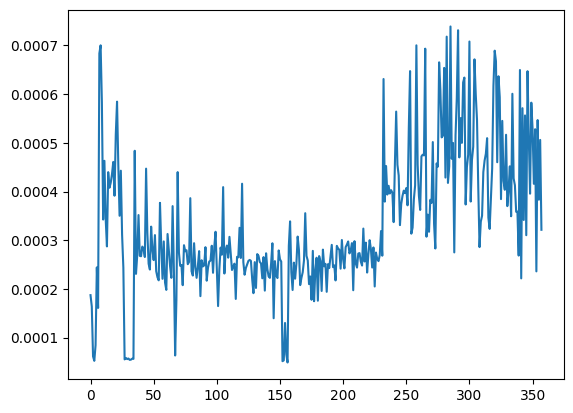

In [228]:
plt.plot(loss)